![Colegio Bourbaki](./Images/Bourbaki.png)

# Procesamiento de Lenguaje Natural

## Clasificador de reclamos del Consumidor

Los datos que se utilizan en este notebook proceden de la Base de Datos de Reclamos de los Consumidores que publica la Oficina de Protección Financiera del Consumidor (CFPB), una agencia gubernamental estadounidense. 

La Base de Datos de Reclamos de los Consumidores es una recopilación de reclamos sobre productos y servicios financieros de consumo que la CFPB envía a las empresas para que respondan. 

Una queja/denuncia/reclamo contiene la descripción narrativa del consumidor sobre su experiencia si el consumidor optó por compartir esta información públicamente y después de que la Oficina haya eliminado toda la información personal.

Los datos están a disposición del público en https://www.consumerfinance.gov/data-research/consumer-complaints/.

### Librerias

In [1]:
#Data Analysis
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

#Classifier
from sklearn.svm import SVC

#Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve,auc

#Utils
import re
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

### Configuraciónes

In [2]:
pd.options.display.max_colwidth = 500

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pdconte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pdconte/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Funciones de ayuda

In [4]:
def generate_wordcloud(texts):
    """ Genera una nube de palabras a partir de una lista de textos """
    # Crear la cadena con la que haremos la nube de palabras
    combined_text = " ".join(text for text in texts)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50, 
                          max_words=100, 
                          background_color="white", 
                          normalize_plurals=False, 
                          collocations=False).generate(combined_text)
    

    # Desplegar la imagen generada
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [5]:
def preprocessing(text):
    # Convertir a minúsculas
    text = text.lower()

    # Quitar Stopwords
    stop = re.compile(r'\b(?:{})\b\s*'.format('|'.join(stopwords.words('english'))))
    text = stop.sub('', text)

    # Tokenizar, eliminar signos de puntuación y números
    words = [word for word in word_tokenize(text) if word.isalpha() and len(word) > 2]

    # Lemmatizar    
    lemma = WordNetLemmatizer()
    words = [lemma.lemmatize(word) for word in words]

    # Reconstruir el texto
    processed_text = ' '.join(words)

    return processed_text

In [6]:
def confusion_matrix(y_real, y_pred):
    """ Muestra la matrix de confusión entre datos reales y predichos por un modelo"""
    data = {'Y_Real': y_real,
            'Y_Prediccion': y_pred
            }

    df = pd.DataFrame(data, columns=['Y_Real', 'Y_Prediccion'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

    sns.heatmap(confusion_matrix, annot=True, fmt='g')
    plt.show()

In [7]:
def plot_roc_curve(y_true, y_score, classes):
    """
    Plot one-vs-all ROC curves for a multi-class classifier.
    """
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=classes)

    # Compute one-vs-all ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        y_true_class = y_true_bin[:, i]
        y_score_class = y_score  # Assuming one-dimensional scores for each class

        fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score_class)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot one-vs-all ROC curves for each class
    plt.figure(figsize=(8, 6))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(len(classes)), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=2,
            label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {classes[i]} vs Rest'
        )

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-All ROC Curves for Multi-class Classifier')
    plt.legend(loc="lower right")
    plt.show()

### Importación de Datos

Los datos pueden descargarse a través de una API desde https://www.consumerfinance.gov/data-research/consumer-complaints/ o descargarse en formato csv en https://files.consumerfinance.gov/ccdb/complaints.csv.zip

Encontraremos una explicación detallada de las columnas disponibles aquí: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

Nuestro análisis se centrará en la columna Producto, que contiene el grupo de productos, y en la columna con el texto del reclamo Relato de la reclamo del consumidor. Como el dataset es muy grande (>3GB) solo importaremos estas dos columnas.

In [8]:
df = pd.read_csv(filepath_or_buffer='./Data/complaints.csv', low_memory=False, usecols=['Consumer complaint narrative', 'Product'])

### Análisis Exploratorio

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4540026 entries, 0 to 4540025
Data columns (total 2 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Product                       object
 1   Consumer complaint narrative  object
dtypes: object(2)
memory usage: 69.3+ MB


In [10]:
df.head()

,Product,Consumer complaint narrative
0,Credit reporting or other personal consumer reports,NaN
1,Credit reporting or other personal consumer reports,NaN
2,Credit reporting or other personal consumer reports,NaN
3,Credit reporting or other personal consumer reports,NaN
4,Credit reporting or other personal consumer reports,NaN


In [11]:
df.isna().sum()

Product                               0
Consumer complaint narrative    2892694
dtype: int64

In [12]:
df.dropna(subset=['Consumer complaint narrative'], inplace=True)

In [13]:
df['Product'].value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    807299
Debt collection                                                                 230696
Mortgage                                                                        112318
Credit card or prepaid card                                                     108666
Credit reporting or other personal consumer reports                              90760
Checking or savings account                                                      84974
Student loan                                                                     39167
Money transfer, virtual currency, or money service                               36172
Credit reporting                                                                 31587
Credit card                                                                      28925
Vehicle loan or lease                                                            27967
Payday loan, title loan, or persona

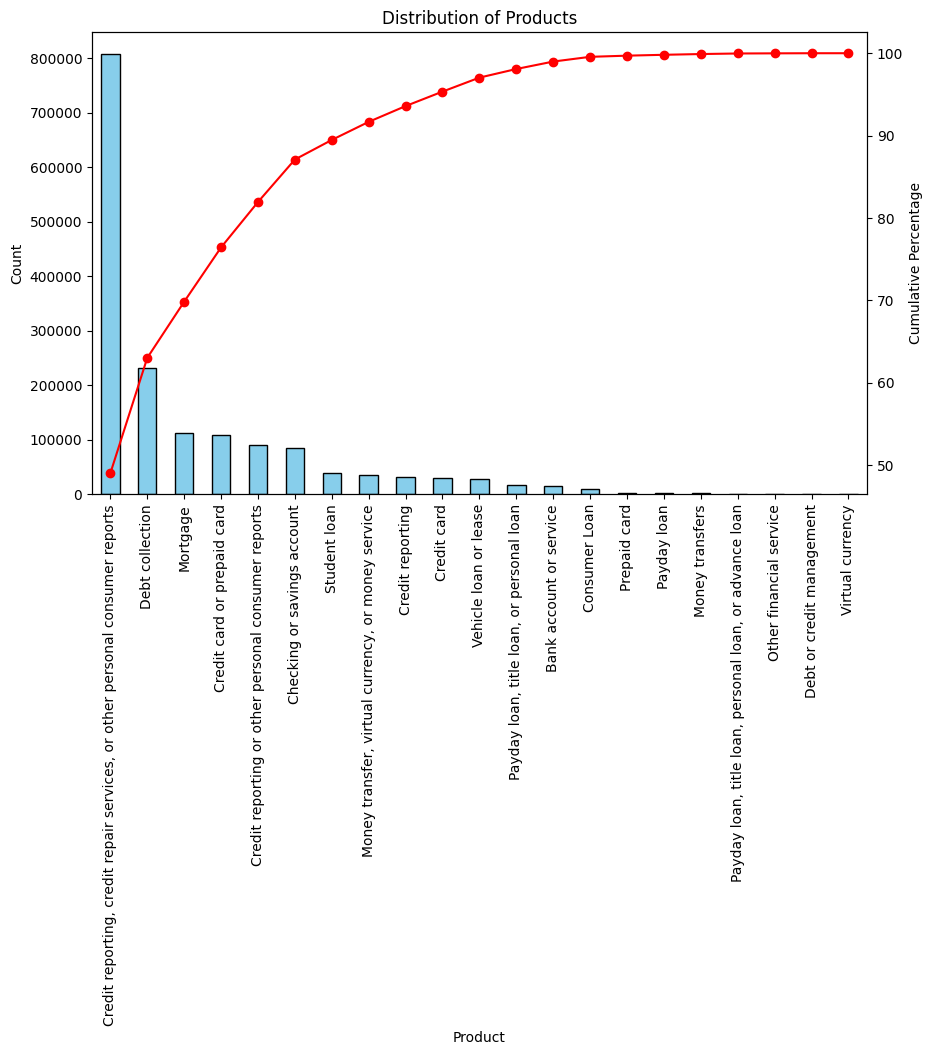

In [14]:
# Plot the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
df['Product'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Products')
plt.xlabel('Product')
plt.ylabel('Count')

# Create a second y-axis for CDF
ax2 = ax1.twinx()
cumulative_counts = df['Product'].value_counts().cumsum()
cumulative_percentages = cumulative_counts / cumulative_counts.max() * 100
cumulative_percentages.plot(kind='line', color='red', ax=ax2, marker='o')
ax2.set_ylabel('Cumulative Percentage')
ax2.tick_params(axis='y')

plt.show()

Como vemos las clases estan muy desbalanceadas: sólo la primera se lleva cerca del 50% de los datos

Por lo tanto, por cuestiones de balanceo y también, de memoria en el preprocessing de los textos, trabajaremos con las 6 primeras etiquetas haciendo un undersampling entre 3500 y 4000 registros.

In [15]:
# Define the list of the first 6 classes
selected_classes = [
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Debt collection',
    'Mortgage',
    'Credit card or prepaid card',
    'Checking or savings account',
    'Credit reporting or other personal consumer reports',
]

In [16]:
filtered_df = df[df['Product'].isin(selected_classes)]

In [17]:
# Set target count range for undersampling
target_count_range = (3500, 4000)

# Undersample the selected classes
undersampled_data = []

for product_class in selected_classes:
    target = np.random.randint(target_count_range[0], target_count_range[1])
    class_subset = filtered_df[filtered_df['Product'] == product_class].sample(n=target, random_state=42)
    undersampled_data.append(class_subset)

# Concatenate the undersampled data
undersampled_df = pd.concat(undersampled_data)

# Shuffle the resulting DataFrame
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

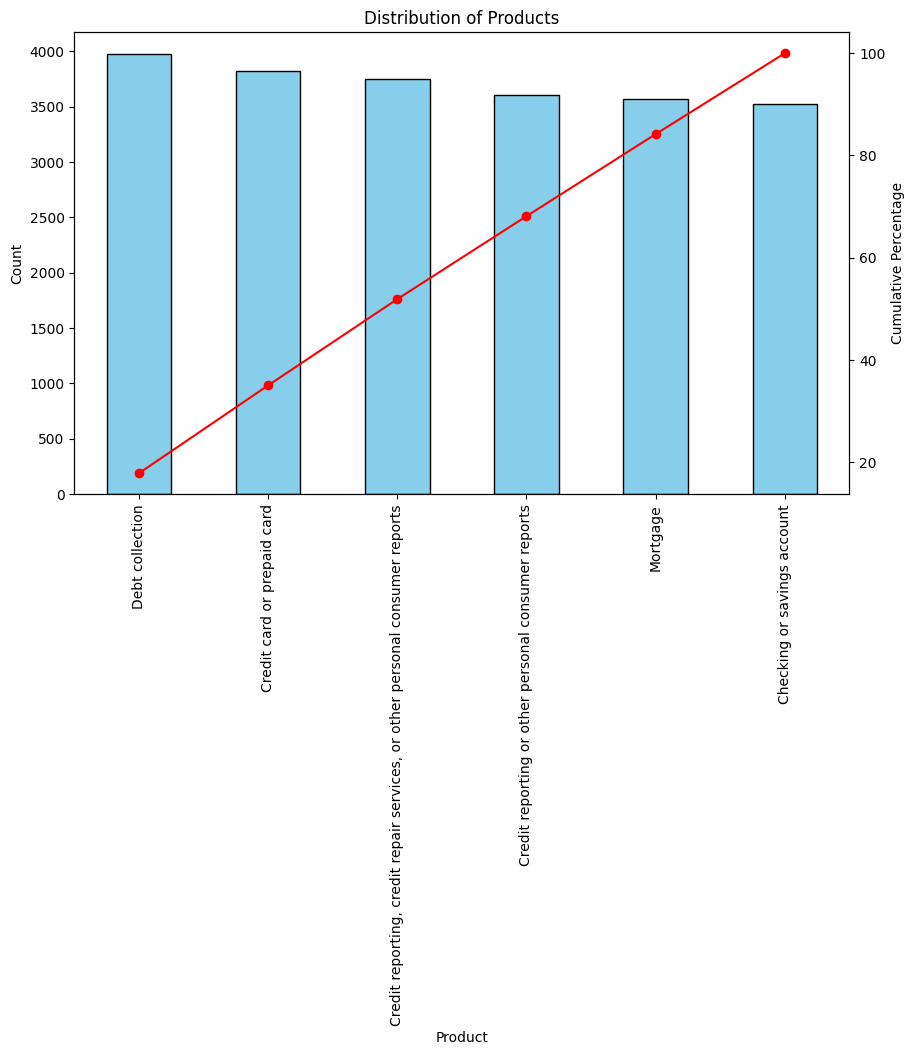

In [18]:
# Plot the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
undersampled_df['Product'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Distribution of Products')
plt.xlabel('Product')
plt.ylabel('Count')


# Create a second y-axis for CDF
ax2 = ax1.twinx()
cumulative_counts = undersampled_df ['Product'].value_counts().cumsum()
cumulative_percentages = cumulative_counts / cumulative_counts.max() * 100
cumulative_percentages.plot(kind='line', color='red', ax=ax2, marker='o')

ax2.set_ylabel('Cumulative Percentage')
ax2.tick_params(axis='y')

In [19]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22240 entries, 850510 to 859594
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       22240 non-null  object
 1   Consumer complaint narrative  22240 non-null  object
dtypes: object(2)
memory usage: 521.2+ KB


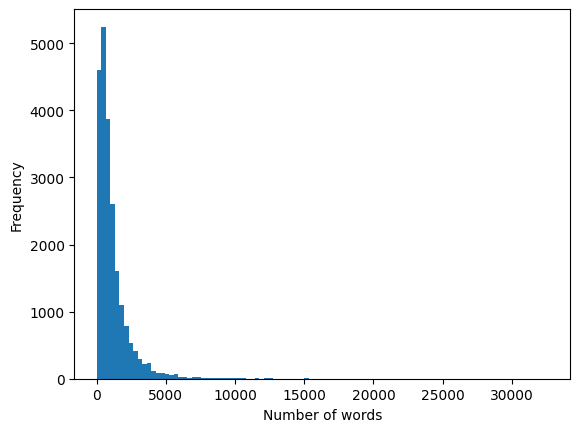

In [20]:
undersampled_df['Consumer complaint narrative'].str.len().plot.hist(bins=100)
plt.xlabel('Number of words')
plt.show()

In [21]:
undersampled_df['Consumer complaint narrative'].str.len().describe()

count    22240.000000
mean      1154.890962
std       1466.167867
min         14.000000
25%        398.000000
50%        757.000000
75%       1377.000000
max      32612.000000
Name: Consumer complaint narrative, dtype: float64

In [22]:
X = undersampled_df['Consumer complaint narrative'].astype(str) # Convertimos la columna a tipo 'string', ya que es 'object'

In [23]:
X = X.transform(preprocessing, axis=0) # Aplicamos la función de preprocesamiento

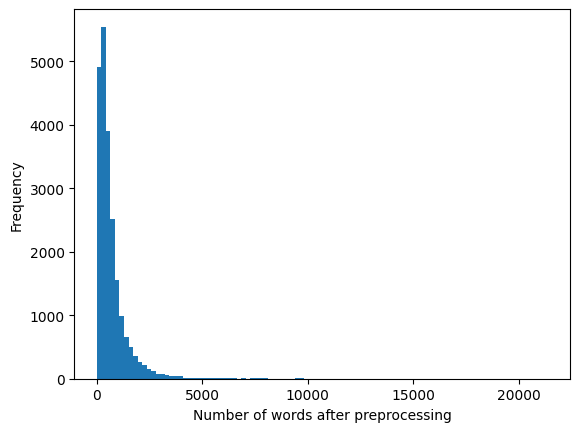

In [24]:
X.str.len().plot.hist(bins=100)
plt.xlabel('Number of words after preprocessing')
plt.show()

In [25]:
X.str.len().describe()

count    22240.000000
mean       702.645728
std        909.993041
min          4.000000
25%        242.000000
50%        462.000000
75%        838.000000
max      21377.000000
Name: Consumer complaint narrative, dtype: float64

In [26]:
all_text = ' '.join(X)
words = all_text.split()
unique_words_count = len(set(word.lower() for word in words))

print(f"Número único de palabras: {unique_words_count}")

Número único de palabras: 22419


Estos análisis nos ofrecen una idea o intuición de cuantás palabras deberiamos usar en nuestro vocabulario. Al parecer 2000 features estarían bien. 

In [27]:
Y = undersampled_df['Product']

In [28]:
Y.value_counts()

Product
Debt collection                                                                 3972
Credit card or prepaid card                                                     3821
Credit reporting, credit repair services, or other personal consumer reports    3752
Credit reporting or other personal consumer reports                             3607
Mortgage                                                                        3569
Checking or savings account                                                     3519
Name: count, dtype: int64

Vamos a mapear las clases tipo 'string' a 'int':

In [29]:
aux = {item: index for index, item in enumerate(selected_classes)}
aux

{'Credit reporting, credit repair services, or other personal consumer reports': 0,
 'Debt collection': 1,
 'Mortgage': 2,
 'Credit card or prepaid card': 3,
 'Checking or savings account': 4,
 'Credit reporting or other personal consumer reports': 5}

In [30]:
Y = Y.map(aux)

In [31]:
Y.value_counts()

Product
1    3972
3    3821
0    3752
5    3607
2    3569
4    3519
Name: count, dtype: int64

Hagamos una visualización usando el concept nube de palabras

In [32]:
ensemble_data = pd.concat([X,Y], axis = 1)

Class:4


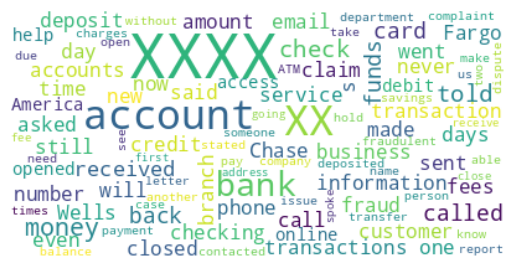

Class:3


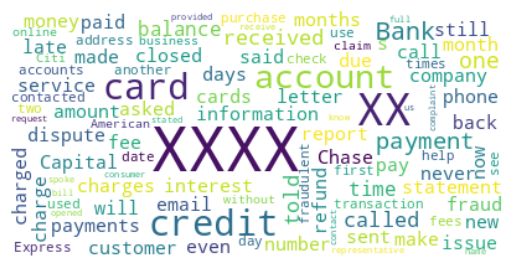

Class:5


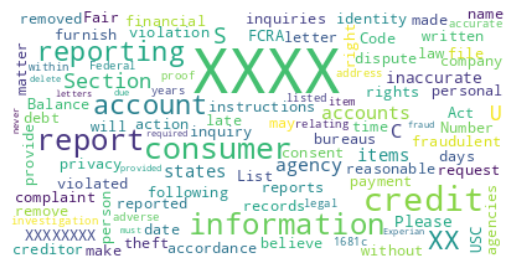

Class:0


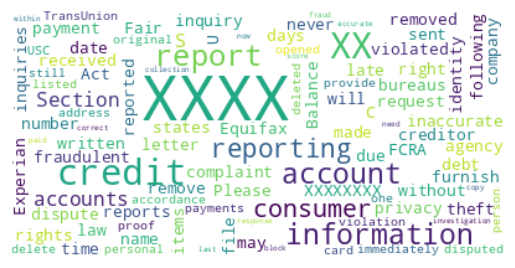

Class:2


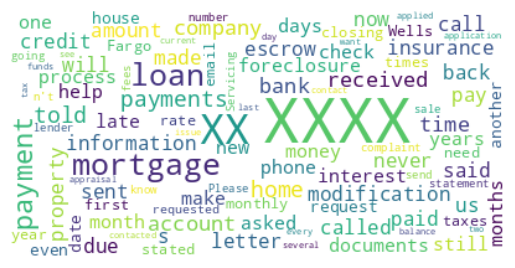

Class:1


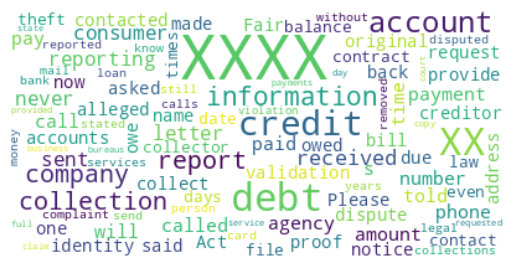

In [33]:
# Iterate over unique values in the 'Product' column
for item in ensemble_data['Product'].unique():
     print(f'Class:{item}')
     # Filter undersampled_df based on the current 'Product' value
     grouping = undersampled_df[ensemble_data['Product'] == item]['Consumer complaint narrative']
     # Generate word cloud for the filtered data
     generate_wordcloud(grouping)

Los string 'XXXX' y 'XX' aparecen contundemente en todas las clases, esto puede sesgar cualquier clasificador, por lo tanto vamos a removerlos.

In [34]:
# Remove 'xxxx' and 'xx' from every record
X = X.str.replace('xxxx', '').str.replace('xx', '')

In [35]:
ensemble_data_cleaned = pd.concat([X,Y], axis = 1)

Class:4


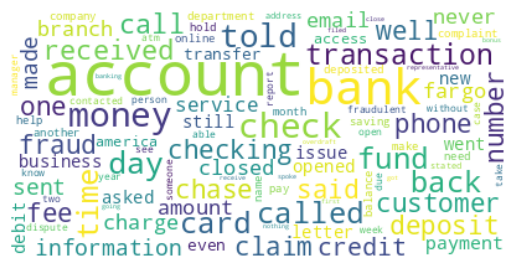

Class:3


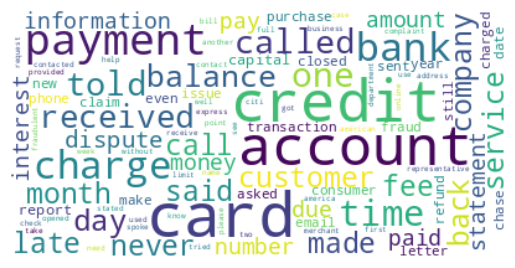

Class:5


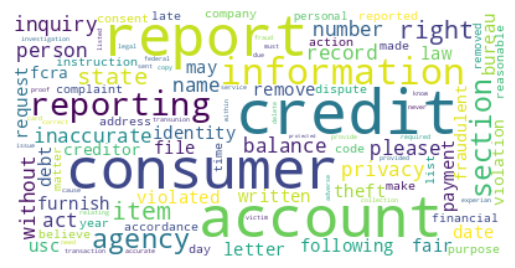

Class:0


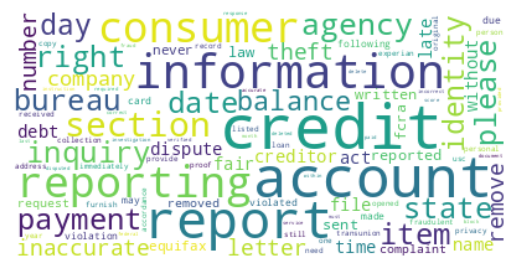

Class:2


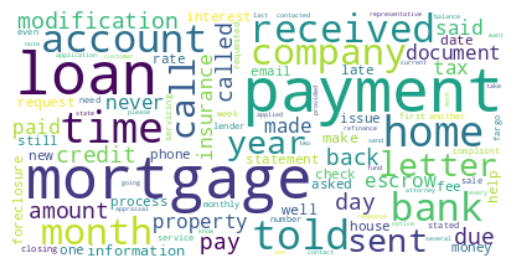

Class:1


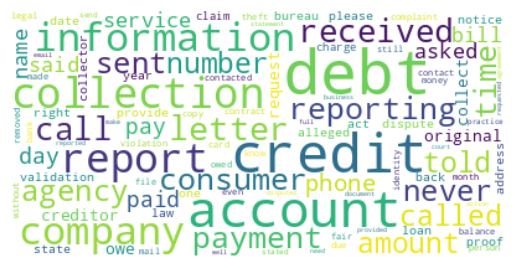

In [36]:
for item in ensemble_data_cleaned['Product'].unique():
    print(f'Class:{item}')
    grouping = ensemble_data_cleaned[ensemble_data_cleaned['Product'] == item]['Consumer complaint narrative']
    generate_wordcloud(grouping)

Separamos en conjunto de entrenamiento y prueba:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Encajes de palabras (Word Embeddings)

¿Existen técnicas para vectorizar eficientemente oraciones desde el principio, cumpliendo con ciertos criterios? 

Consideraciones clave incluyen: 

* Evitar la generación de matrices dispersas debido a sus altos costos computacionales asociados
* Asegurar la retención de información lingüística sustancial dentro de la oración.

Una técnica efectiva para lograr esto es el **Word Embedding**, un método que representa el texto mediante vectores. Entre las formas populares de embeddings de palabras se encuentran la Bolsa de Palabras (BoW) y la Frecuencia de Términos-Inversa de Frecuencia en el Documento (TF-IDF).

Veamos cómo podemos aplicar estos métodos a nuestro dataset:

#### Bolsa de palabras (BoW)

Es el módelo mas simples para representar el texto mediante números. Podemos representar una oración como una bolsa de palabras vectorizada (una cadena de números).

Algunas desventajas:

* Si la oración contiene nuevas palabras, entonces el tamaño de nuestro vocabulario se incrementaría, y por lo tanto, el tamaño de nuestros vectores.

* Si los vectores contienen muchos 0's, la matriz resultante de palabras sería dispesa (es algo que queremos evitar por su alto costo computacional).

* No retenemos información acerca de la grámatica y semántica de las palabras o aún en el orden de las palabras en el texto.

In [38]:
# Bag of Words (BoW) representation
bow_vectorizer = CountVectorizer(max_features=2000) #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [39]:
X_train_bow.shape

(17792, 2000)

In [40]:
words = bow_vectorizer.get_feature_names_out()
pd.DataFrame(X_train_bow.todense(), columns=words)

,ability,able,absolutely,abuse,abusive,accept,acceptable,acceptance,accepted,access,...,write,writing,written,wrong,wrote,year,yes,yesterday,yet,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17788,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
17789,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
17790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
L2 = 1 #The strength of the regularization is inversely proportional to C (The penalty is a squared l2 penalty)

In [42]:
# Train SVM with BoW
svm_classifier_bow = SVC(C=L2, kernel='linear')
svm_classifier_bow.fit(X_train_bow, y_train)
y_pred_bow = svm_classifier_bow.predict(X_test_bow)

In [43]:
# Evaluate SVM with BoW
print("Classification Report using SVM with BoW:\n", classification_report(y_test, y_pred_bow))
print("Accuracy using SVM with BoW:", accuracy_score(y_test, y_pred_bow))

Classification Report using SVM with BoW:
               precision    recall  f1-score   support

           0       0.54      0.62      0.58       778
           1       0.73      0.75      0.74       787
           2       0.89      0.90      0.89       685
           3       0.78      0.74      0.76       769
           4       0.83      0.80      0.81       692
           5       0.66      0.59      0.63       737

    accuracy                           0.73      4448
   macro avg       0.74      0.73      0.73      4448
weighted avg       0.73      0.73      0.73      4448

Accuracy using SVM with BoW: 0.729091726618705


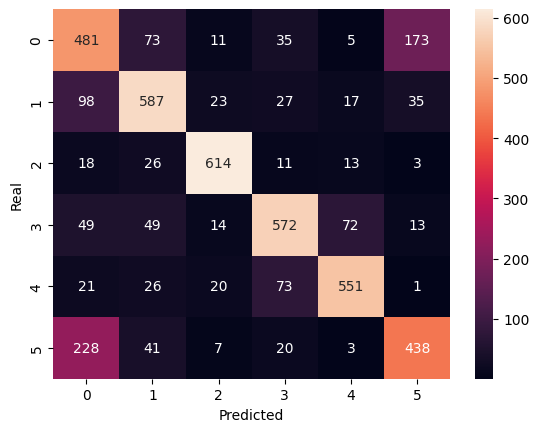

In [44]:
confusion_matrix(y_test, y_pred_bow)

In [45]:
classes =  ensemble_data_cleaned['Product'].unique().tolist()

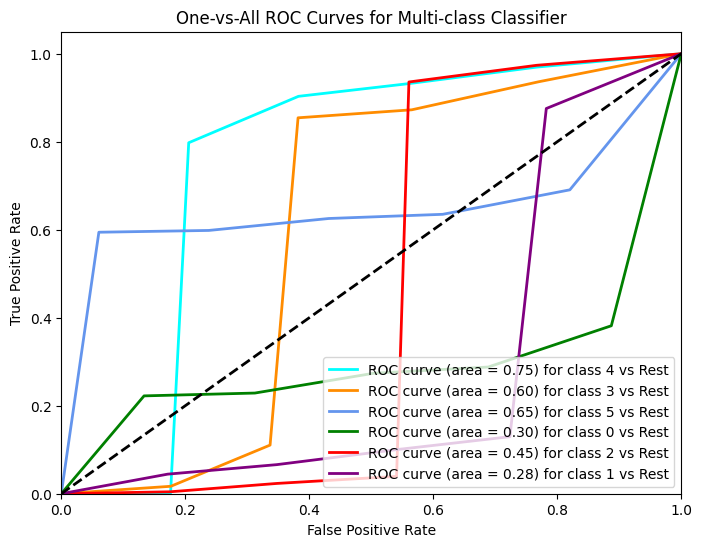

In [46]:
plot_roc_curve(y_test, y_pred_bow, classes)

#### Frecuencia del Término - Frecuencia Inversa de los Documentos (TF-IDF)

Es un método estadístico que intenta reflejar cuán imporante es una palabra en un documento dentro de un corpus o colección de textos.

**Frequencia del Término:** Es una medida de cuán importante es un término a partir de cuantas veces aparece porcentualmente en un documento.

**Frecuencia Inversa de los Documentos:** es una medida de cuán importante es un término en general. Necesitamos este cálculo porque solo calcular la frecuencia del término no es suficiente para entender la importancia de las palabras.

Comparando con BoW, este primero crea un conjunto de vectores fáciles de interpretar conteniendo la cuenta de ocurrencias de una palabras en un documento, mientras que el segundo contiene información sobre las palabras más importantes y también de las menos importante. Por lo tanto, TF-IDF suele tener mejor performance en los modelos de ML.


In [47]:
# TF-IDF model
tfidf_vectorizer = TfidfVectorizer(max_features=2000) #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [48]:
X_train_tfidf.shape

(17792, 2000)

In [49]:
words = tfidf_vectorizer.get_feature_names_out()
pd.DataFrame(X_train_tfidf.todense(), columns=words)

,ability,able,absolutely,abuse,abusive,accept,acceptable,acceptance,accepted,access,...,write,writing,written,wrong,wrote,year,yes,yesterday,yet,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.030848,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
17788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.245637,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
17789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103176,...,0.0,0.000000,0.0,0.0,0.0,0.071230,0.0,0.0,0.0,0.0
17790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [50]:
svm_classifier_tfidf = SVC(C=L2, kernel='linear')
svm_classifier_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm_classifier_tfidf.predict(X_test_tfidf)

In [51]:
print("Classification Report using TF-IDF:\n", classification_report(y_test, y_pred_tfidf))
print("\nAccuracy using SVM with TF-IDF:", accuracy_score(y_test, y_pred_tfidf))

Classification Report using TF-IDF:
               precision    recall  f1-score   support

           0       0.58      0.62      0.60       778
           1       0.82      0.82      0.82       787
           2       0.93      0.94      0.93       685
           3       0.84      0.83      0.83       769
           4       0.86      0.88      0.87       692
           5       0.68      0.61      0.64       737

    accuracy                           0.78      4448
   macro avg       0.78      0.78      0.78      4448
weighted avg       0.78      0.78      0.78      4448


Accuracy using SVM with TF-IDF: 0.7805755395683454


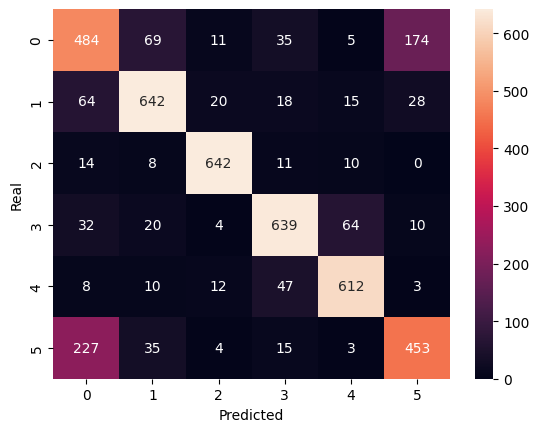

In [52]:
confusion_matrix(y_test, y_pred_tfidf)

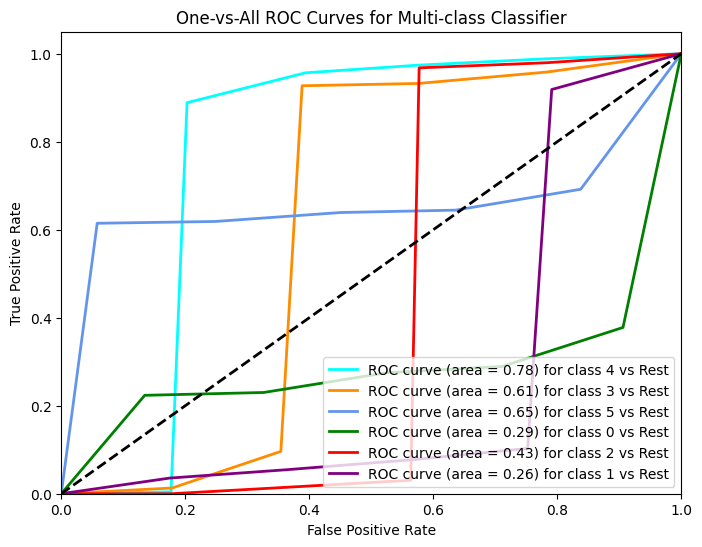

In [53]:
plot_roc_curve(y_test, y_pred_tfidf, classes)

Observemos que la clasificación es mejor con el acercamiento TF-IDF que BOW.

Por otro lado, veamos que la clasificación falla en la clases 0 y 5.

Veamos sus nombres:

In [54]:
aux

{'Credit reporting, credit repair services, or other personal consumer reports': 0,
 'Debt collection': 1,
 'Mortgage': 2,
 'Credit card or prepaid card': 3,
 'Checking or savings account': 4,
 'Credit reporting or other personal consumer reports': 5}

Las 2 clases tienen nombres muy similares, por lo tanto, seguro agrupan contenido muy parecido. 

PREGUNTA: Podrían establecer algún tipo de métrica de similitud para poder juntar estar clases, es decir, que tan parecidas son las cadenas de textos en la clase 0 y la clase 5?

### Ejercicio

* Mejorar la clasificación con otros kernels, clasificadores, regularizaciones y/o haciendo mas eficiente la bolsa de palabras y el TD-IDF si es posible. Para esto explorar que otros clasificadores podrían usar, hacer más exhaustivo el analisis exploratorio y preprocesamiento, y revisar los links de scikit-learn para ver qué otros parámetros pueden usarse dentro de las clases CountVectorizer y TFIDFVectorizer. Tener en cuenta también el costo computacional debido a la maldición de la dimensión que sufren las matrices creadas por las clases ya nombradas.

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)